# Import and misc

In [1]:
# Instal latest torch and torchaudio

In [2]:
from typing import Tuple, Union, List, Callable, Optional
from tqdm import tqdm
from itertools import islice
import pathlib
import dataclasses

import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
from torch import nn
from torch import distributions
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torch.nn.utils.rnn import pad_sequence

import torchaudio
from IPython import display as display_

from utils import set_random_seed

set_random_seed(3407)
MODEL_FOLDER = "./model/"

# Task

In this notebook we will implement a model for finding a keyword in a stream.

We will implement the version with CRNN because it is easy and improves the model. 
(from https://www.dropbox.com/s/22ah2ba7dug6pzw/KWS_Attention.pdf)

In [3]:
@dataclasses.dataclass
class TaskConfig:
    keyword: str = 'sheila'  # We will use 1 key word -- 'sheila'
    batch_size: int = 128
    learning_rate: float = 3e-4
    weight_decay: float = 1e-5
    num_epochs: int = 20
    n_mels: int = 40
    cnn_out_channels: int = 8
    kernel_size: Tuple[int, int] = (5, 20)
    stride: Tuple[int, int] = (2, 8)
    hidden_size: int = 64
    gru_num_layers: int = 2
    bidirectional: bool = False
    num_classes: int = 2
    sample_rate: int = 16000
    device: torch.device = torch.device(
        'cuda:0' if torch.cuda.is_available() else 'cpu')

# Data

In [4]:
# !wget http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz -O speech_commands_v0.01.tar.gz
# !mkdir speech_commands && tar -C speech_commands -xvzf speech_commands_v0.01.tar.gz 1> log

In [5]:
class SpeechCommandDataset(Dataset):

    def __init__(
        self,
        transform: Optional[Callable] = None,
        path2dir: str = None,
        keywords: Union[str, List[str]] = None,
        csv: Optional[pd.DataFrame] = None
    ):        
        self.transform = transform

        if csv is None:
            path2dir = pathlib.Path(path2dir)
            keywords = keywords if isinstance(keywords, list) else [keywords]
            
            all_keywords = [
                p.stem for p in path2dir.glob('*')
                if p.is_dir() and not p.stem.startswith('_')
            ]

            triplets = []
            for keyword in all_keywords:
                paths = (path2dir / keyword).rglob('*.wav')
                if keyword in keywords:
                    for path2wav in paths:
                        triplets.append((path2wav.as_posix(), keyword, 1))
                else:
                    for path2wav in paths:
                        triplets.append((path2wav.as_posix(), keyword, 0))
            
            self.csv = pd.DataFrame(
                triplets,
                columns=['path', 'keyword', 'label']
            )

        else:
            self.csv = csv
    
    def __getitem__(self, index: int):
        instance = self.csv.iloc[index]

        path2wav = instance['path']
        wav, sr = torchaudio.load(path2wav)
        wav = wav.sum(dim=0)
        
        if self.transform:
            wav = self.transform(wav)

        return {
            'wav': wav,
            'keywors': instance['keyword'],
            'label': instance['label']
        }

    def __len__(self):
        return len(self.csv)

In [6]:
dataset = SpeechCommandDataset(
    path2dir='speech_commands', keywords=TaskConfig.keyword
)

In [7]:
dataset.csv.sample(5)

,path,keyword,label
11157,speech_commands/wow/db43cd03_nohash_0.wav,wow,0
2437,speech_commands/two/4e8c5516_nohash_1.wav,two,0
9857,speech_commands/bird/de650823_nohash_0.wav,bird,0
2850,speech_commands/sheila/21cbe292_nohash_1.wav,sheila,1
27190,speech_commands/yes/106a6183_nohash_0.wav,yes,0


### Augmentations

In [8]:
class AugsCreation:

    def __init__(self):
        self.background_noises = [
            'speech_commands/_background_noise_/white_noise.wav',
            'speech_commands/_background_noise_/dude_miaowing.wav',
            'speech_commands/_background_noise_/doing_the_dishes.wav',
            'speech_commands/_background_noise_/exercise_bike.wav',
            'speech_commands/_background_noise_/pink_noise.wav',
            'speech_commands/_background_noise_/running_tap.wav'
        ]

        self.noises = [
            torchaudio.load(p)[0].squeeze()
            for p in self.background_noises
        ]

    def add_rand_noise(self, audio):

        # randomly choose noise
        noise_num = torch.randint(low=0, high=len(
            self.background_noises), size=(1,)).item()
        noise = self.noises[noise_num]

        noise_level = torch.Tensor([1])  # [0, 40]

        noise_energy = torch.norm(noise)
        audio_energy = torch.norm(audio)
        alpha = (audio_energy / noise_energy) * \
            torch.pow(10, -noise_level / 20)

        start = torch.randint(
            low=0,
            high=max(int(noise.size(0) - audio.size(0) - 1), 1),
            size=(1,)
        ).item()
        noise_sample = noise[start: start + audio.size(0)]

        audio_new = audio + alpha * noise_sample
        audio_new.clamp_(-1, 1)
        return audio_new

    def __call__(self, wav):
        aug_num = torch.randint(low=0, high=4, size=(1,)).item()   # choose 1 random aug from augs
        augs = [
            lambda x: x,
            lambda x: (x + distributions.Normal(0, 0.01).sample(x.size())).clamp_(-1, 1),
            lambda x: torchaudio.transforms.Vol(.25)(x),
            lambda x: self.add_rand_noise(x)
        ]

        return augs[aug_num](wav)

In [9]:
indexes = torch.randperm(len(dataset))
train_indexes = indexes[:int(len(dataset) * 0.8)]
val_indexes = indexes[int(len(dataset) * 0.8):]

train_df = dataset.csv.iloc[train_indexes].reset_index(drop=True)
val_df = dataset.csv.iloc[val_indexes].reset_index(drop=True)

In [10]:
# Sample is a dict of utt, word and label
train_set = SpeechCommandDataset(csv=train_df, transform=AugsCreation())
val_set = SpeechCommandDataset(csv=val_df)


### Sampler for oversampling:

In [11]:
# We should provide to WeightedRandomSampler _weight for every sample_; by default it is 1/len(target)

def get_sampler(target):
    class_sample_count = np.array(
        [len(np.where(target == t)[0]) for t in np.unique(target)])   # for every class count it's number of occ.
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[t] for t in target])
    samples_weight = torch.from_numpy(samples_weight)
    samples_weigth = samples_weight.float()
    sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
    return sampler

In [12]:
train_sampler = get_sampler(train_set.csv['label'].values)

In [13]:
class Collator:
    
    def __call__(self, data):
        wavs = []
        labels = []    

        for el in data:
            wavs.append(el['wav'])
            labels.append(el['label'])

        # torch.nn.utils.rnn.pad_sequence takes list(Tensors) and returns padded (with 0.0) Tensor
        wavs = pad_sequence(wavs, batch_first=True)    
        labels = torch.Tensor(labels).long()
        return wavs, labels

###  Dataloaders

In [14]:
# Here we are obliged to use shuffle=False because of our sampler with randomness inside.

train_loader = DataLoader(train_set, batch_size=TaskConfig.batch_size,
                          shuffle=False, collate_fn=Collator(),
                          sampler=train_sampler,
                          num_workers=6, pin_memory=True)

val_loader = DataLoader(val_set, batch_size=TaskConfig.batch_size,
                        shuffle=False, collate_fn=Collator(),
                        num_workers=6, pin_memory=True)

### Creating MelSpecs on GPU for speeeed: 

In [15]:
class LogMelspec:

    def __init__(self, is_train, config):
        # with augmentations
        if is_train:
            self.melspec = nn.Sequential(
                torchaudio.transforms.MelSpectrogram(
                    sample_rate=config.sample_rate,
                    n_fft=400,
                    win_length=400,
                    hop_length=160,
                    n_mels=config.n_mels
                ),
                torchaudio.transforms.FrequencyMasking(freq_mask_param=15),
                torchaudio.transforms.TimeMasking(time_mask_param=35),
            ).to(config.device)

        # no augmentations
        else:
            self.melspec = torchaudio.transforms.MelSpectrogram(
                sample_rate=config.sample_rate,
                n_fft=400,
                win_length=400,
                hop_length=160,
                n_mels=config.n_mels
            ).to(config.device)

    def __call__(self, batch):
        # already on device
        return torch.log(self.melspec(batch).clamp_(min=1e-9, max=1e9))

In [16]:
melspec_train = LogMelspec(is_train=True, config=TaskConfig)
melspec_val = LogMelspec(is_train=False, config=TaskConfig)

### Quality measurment functions:

In [17]:
# FA - true: 0, model: 1
# FR - true: 1, model: 0

def count_FA_FR(preds, labels):
    FA = torch.sum(preds[labels == 0])
    FR = torch.sum(labels[preds == 0])
    
    # torch.numel - returns total number of elements in tensor
    return FA.item() / torch.numel(preds), FR.item() / torch.numel(preds)

In [18]:
def get_au_fa_fr(probs, labels):
    sorted_probs, _ = torch.sort(probs)
    sorted_probs = torch.cat((torch.Tensor([0]), sorted_probs, torch.Tensor([1])))
    labels = torch.cat(labels, dim=0)
        
    FAs, FRs = [], []
    for prob in sorted_probs:
        preds = (probs >= prob) * 1
        FA, FR = count_FA_FR(preds, labels)        
        FAs.append(FA)
        FRs.append(FR)
    # plt.plot(FAs, FRs)
    # plt.show()

    # ~ area under curve using trapezoidal rule
    return -np.trapz(FRs, x=FAs)

# Model

In [19]:
class Attention(nn.Module):

    def __init__(self, hidden_size: int):
        super().__init__()

        self.energy = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )
    
    def forward(self, input):
        energy = self.energy(input)
        alpha = torch.softmax(energy, dim=-2)
        return (input * alpha).sum(dim=-2)

class CRNN(nn.Module):

    def __init__(self, config: TaskConfig):
        super().__init__()
        self.config = config

        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=config.cnn_out_channels,
                kernel_size=config.kernel_size, stride=config.stride
            ),
            nn.Flatten(start_dim=1, end_dim=2),
        )

        self.conv_out_frequency = (config.n_mels - config.kernel_size[0]) // \
            config.stride[0] + 1
        
        self.gru = nn.GRU(
            input_size=self.conv_out_frequency * config.cnn_out_channels,
            hidden_size=config.hidden_size,
            num_layers=config.gru_num_layers,
            dropout=0.1,
            bidirectional=config.bidirectional,
            batch_first=True
        )

        self.attention = Attention(config.hidden_size)
        self.classifier = nn.Linear(config.hidden_size, config.num_classes)
    
    def forward(self, input):
        input = input.unsqueeze(dim=1)
        conv_output = self.conv(input).transpose(-1, -2)
        gru_output, _ = self.gru(conv_output)
        contex_vector = self.attention(gru_output)
        output = self.classifier(contex_vector)
        return output

config = TaskConfig()
model = CRNN(config)
model

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 64, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)

In [20]:
def train_epoch(model, opt, loader, log_melspec, device, scheduler=None):
    model.train()
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch = batch.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        batch = log_melspec(batch)

        opt.zero_grad()

        # run model # with autocast():
        logits = model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(logits, dim=-1)
        loss = F.cross_entropy(logits, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

        opt.step()
        if scheduler:
            scheduler.step()

In [21]:
@torch.no_grad()
def validation(model, loader, log_melspec, device):
    model.eval()

    val_losses, accs, FAs, FRs = [], [], [], []
    all_probs, all_labels = [], []
    for i, (batch, labels) in tqdm(enumerate(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        output = model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(output, dim=-1)
        loss = F.cross_entropy(output, labels)

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        all_probs.append(probs[:, 1].cpu())
        all_labels.append(labels.cpu())
        val_losses.append(loss.item())
        accs.append(
            torch.sum(argmax_probs == labels).item() /  # ???
            torch.numel(argmax_probs)
        )
        FA, FR = count_FA_FR(argmax_probs, labels)
        FAs.append(FA)
        FRs.append(FR)

    # area under FA/FR curve for whole loader
    au_fa_fr = get_au_fa_fr(torch.cat(all_probs, dim=0).cpu(), all_labels)
    return au_fa_fr

In [22]:
from collections import defaultdict
from IPython.display import clear_output
from matplotlib import pyplot as plt

history = defaultdict(list)

# Training

In [23]:
config = TaskConfig(hidden_size=32)
model = CRNN(config).to(config.device)

print(model)

opt = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 32, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=32, out_features=2, bias=True)
)


In [24]:
sum([p.numel() for p in model.parameters()])


25387

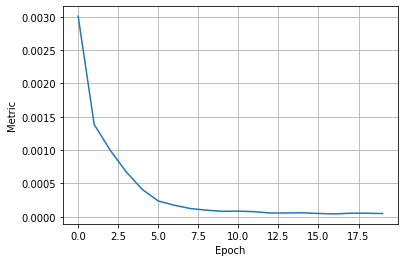

END OF EPOCH 19


In [25]:
# TRAIN

for n in range(TaskConfig.num_epochs):

    train_epoch(model, opt, train_loader,
                melspec_train, config.device)

    au_fa_fr = validation(model, val_loader,
                          melspec_val, config.device)
    history['val_metric'].append(au_fa_fr)

    clear_output()
    plt.plot(history['val_metric'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()

    print('END OF EPOCH', n)

In [26]:
history

defaultdict(list,
            {'val_metric': [0.003008707558935738,
              0.0013857147703487602,
              0.0009988521633006813,
              0.0006741164506594483,
              0.0004110790232880702,
              0.00023815666696905038,
              0.00017407960098889556,
              0.0001246181065801339,
              0.00010014452485794768,
              8.222866293172378e-05,
              8.529321826120945e-05,
              7.71496446583804e-05,
              5.7497915727342955e-05,
              5.781937258008621e-05,
              6.073391471162503e-05,
              5.0425864966991416e-05,
              4.3653840602533575e-05,
              5.4240486286211334e-05,
              5.359757258072484e-05,
              4.9675798977257166e-05]})

### Reproduce

In [173]:
history = defaultdict(list)
config = TaskConfig(hidden_size=32, learning_rate=1e-3, weight_decay=1e-3, num_epochs=35)
model = CRNN(config).to(config.device)

print(model)

opt = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=30, gamma=1)

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 32, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=32, out_features=2, bias=True)
)


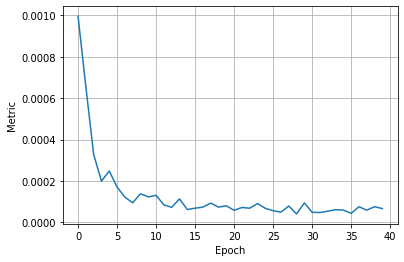

END OF EPOCH 34


<All keys matched successfully>

In [175]:
# TRAIN

from copy import deepcopy

best_val = 1
for n in range(config.num_epochs):

    train_epoch(model, opt, train_loader,
                melspec_train, config.device, scheduler=scheduler)

    au_fa_fr = validation(model, val_loader,
                          melspec_val, config.device)
    history['val_metric'].append(au_fa_fr)

    if au_fa_fr < best_val:
        baseline_dict = {'model': deepcopy(model.state_dict()),
                         'opt': deepcopy(opt.state_dict())}
        best_val = au_fa_fr


    clear_output()
    plt.plot(history['val_metric'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()

    print('END OF EPOCH', n)

torch.save(baseline_dict, MODEL_FOLDER + "baseline.pt")
baseline_model = CRNN(config=config).cuda()
baseline_model.load_state_dict(baseline_dict["model"])

## Начинаем делать домашку

In [134]:
from thop import profile
from utils import Timer

def get_model_info(model, val_loader, melspec_val, config, name="baseline_model", is_quatized=False):
    with Timer(name=name, verbose=True) as timer:
        val = validation(model, val_loader, melspec_val, config.device)
    macs = params = "INCORRECT"
    if not is_quatized:
        mdl = deepcopy(model)
        macs, params = profile(mdl, (torch.randn(1, config.n_mels, 201).cuda(),))
    print("Значение метрики для модели:", val)
    print("Максимально допустимое значение метрики:", 5e-5 * 1.1)
    print("Baseline MACs:", macs)
    print("Baseline params:", params)
    print("Размер свёрточного слоя в байтах:",
          sum([p.numel() * p.element_size() for p in model.conv.parameters() if p.requires_grad]))
    print("Размер рекуррентного слоя в байтах:",
                sum([p.numel() * p.element_size() for p in model.gru.parameters() if p.requires_grad]))
    print("Размер слоя attention в байтах:",
                sum([p.numel() * p.element_size() for p in model.attention.parameters() if p.requires_grad]))
    print("Размер классификационного слоя в байтах:",
                sum([p.numel() * p.element_size() for p in model.classifier.parameters() if p.requires_grad]))

Выведем всю полезную информацию о качестве и размере бейзлайновой модели:

In [176]:
config = TaskConfig(hidden_size=32)
baseline_dict = torch.load(MODEL_FOLDER + "baseline.pt")
baseline_model = CRNN(config=config).cuda()
baseline_model.load_state_dict(baseline_dict["model"])

get_model_info(baseline_model, val_loader, melspec_val, config)

54it [00:01, 51.30it/s]


Baseline_model | Elapsed time : 2.77
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
Значение метрики для модели: 4.099646395318937e-05
Максимально допустимое значение метрики: 5.500000000000001e-05
Baseline MACs: 904608.0
Baseline params: 25387.0
Размер свёрточного слоя в байтах: 3232
Размер рекуррентного слоя в байтах: 93696
Размер слоя attention в байтах: 4356
Размер классификационного слоя в байтах: 264


### Compression

Начнём с knowledge distilation свёрточного и рекуррентного слоя.
Свёрточный слой, конечно, и так не очень большой, но если мы сможем там выиграть, то почему бы и нет.

Для начала напишем функцию обучения модели-студента. В качестве reference я использую слайд про response-based
knowledge distilation с шестой лекции.

In [25]:
def distil_train_one_epoch(student_model, teacher_model, opt, scheduler, loader,
                           T, log_melspec, device, loss_coeffs):
    student_model.train()
    teacher_model.train()
    for idx, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch = batch.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        batch = log_melspec(batch)

        opt.zero_grad()
        teacher_logits = teacher_model(batch).detach()
        student_logits = student_model(batch)
        teacher_soft_targets = F.softmax(teacher_logits / T, dim=-1)
        student_soft_targets = F.softmax(student_logits / T, dim=-1)

        distil_loss = F.cross_entropy(student_soft_targets, teacher_soft_targets)
        student_loss = F.cross_entropy(student_soft_targets, labels)
        loss = loss_coeffs[0] * distil_loss + loss_coeffs[1] * student_loss

        loss.backward()
        torch.nn.utils.clip_grad_norm_(student_model.parameters(), 5)
        opt.step()
        scheduler.step()

def define_model(cfg):
    model = CRNN(cfg).to(cfg.device)
    opt = torch.optim.Adam(
        model.parameters(),
        lr=cfg.learning_rate,
        weight_decay=cfg.weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=30, gamma=1)
    return model, opt, scheduler

In [33]:

distil_config_1 = TaskConfig(num_epochs=35, cnn_out_channels=4, hidden_size=32)
model_name = "distil_model_1"
distil_model, opt, scheduler = define_model(distil_config_1)

softmax_T = 3
loss_coeffs = (1, 0.5)

In [27]:
from copy import deepcopy

def train(teacher_model, distil_model, opt, scheduler, softmax_T,
                melspec_train, config, loss_coeffs,
                val_loader, melspec_val, model_name="snapshot"):
    history = defaultdict(list)
    best_val = 1
    for n in range(config.num_epochs):

        distil_train_one_epoch(distil_model, teacher_model, opt, scheduler, train_loader, softmax_T,
                    melspec_train, config.device, loss_coeffs)

        au_fa_fr = validation(distil_model, val_loader,
                            melspec_val, config.device)
        history['val_metric'].append(au_fa_fr)

        if au_fa_fr < best_val:
            distil_model_dict = {'model': deepcopy(distil_model.state_dict()),
                             'opt': deepcopy(opt.state_dict())}
            best_val = au_fa_fr


        clear_output()
        plt.plot(history['val_metric'])
        plt.ylabel('Metric')
        plt.xlabel('Epoch')
        plt.grid()
        plt.show()

    torch.save(distil_model_dict, MODEL_FOLDER + f"{model_name}.pt")
    distil_model = CRNN(config=config).to(config.device).half()
    distil_model.load_state_dict(distil_model_dict["model"])
    return history, distil_model_dict

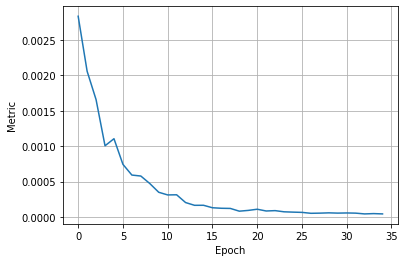

In [35]:
_, distil_model_dict = train(baseline_model, distil_model, opt, scheduler, softmax_T,
                          melspec_train, distil_config_1, loss_coeffs,
                          val_loader, melspec_val)
torch.save(distil_model_dict, MODEL_FOLDER + model_name)


In [36]:
get_model_info(distil_model, val_loader, melspec_val, distil_config_1, name=model_name)

54it [00:01, 39.37it/s]


Distil_model_1 | Elapsed time : 3.56
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
Значение метрики для модели: 4.3182370551843476e-05
Максимально допустимое значение метрики: 5.500000000000001e-05
Baseline MACs: 277440.0
Baseline params: 18071.0
Размер свёрточного слоя в байтах: 1616
Размер рекуррентного слоя в байтах: 66048
Размер слоя attention в байтах: 4356
Размер классификационного слоя в байтах: 264


Интересный эффект: модель стала меньше, работает быстрее, и качество при этом лучше (вероятно из-за того что мы её дольше обучаем).
Это нам на руку, учитывая, что дальше мы будем её сжимать сильнее. Пока мы только существенно уменьшили свёрточный слой.
Рекуррентный при этом тоже сжался, но не очень сильно. Теперь дополнительно уменьшим hidden_size, за счёт чего сильнее сожмётся рекуррентный слой.

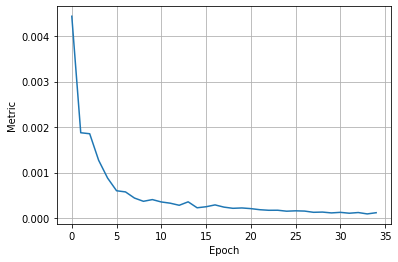

In [37]:
distil_config_2 = TaskConfig(num_epochs=35, cnn_out_channels=4, hidden_size=16)
model_name = "distil_model_2"
distil_model, opt, scheduler = define_model(distil_config_2)

_, distil_model_dict = train(baseline_model, distil_model, opt, scheduler, softmax_T,
                          melspec_train, distil_config_2, loss_coeffs,
                          val_loader, melspec_val)
torch.save(distil_model_dict, MODEL_FOLDER + model_name)

In [38]:
get_model_info(distil_model, val_loader, melspec_val, distil_config_2, name=model_name)

54it [00:01, 41.39it/s]


Distil_model_2 | Elapsed time : 3.49
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
Значение метрики для модели: 0.00011783536698725131
Максимально допустимое значение метрики: 5.500000000000001e-05
Baseline MACs: 150160.0
Baseline params: 6679.0
Размер свёрточного слоя в байтах: 1616
Размер рекуррентного слоя в байтах: 23808
Размер слоя attention в байтах: 1156
Размер классификационного слоя в байтах: 136


Получилось неудачно: MACs стало в два раза меньше, но при этом модель работает довольно долго,
и показывает слишком низкое качетво. Попробуем немного поднять hidden_size:

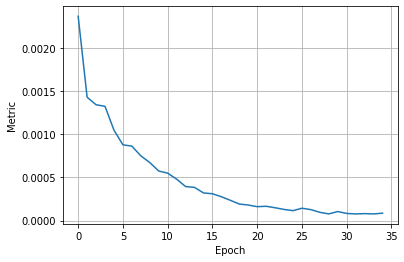

In [40]:
distil_config_3 = TaskConfig(num_epochs=35, cnn_out_channels=4, hidden_size=20)
model_name = "distil_model_3"
distil_model, opt, scheduler = define_model(distil_config_3)

_, distil_model_dict = train(baseline_model, distil_model, opt, scheduler, softmax_T,
                          melspec_train, distil_config_3, loss_coeffs,
                          val_loader, melspec_val)
torch.save(distil_model_dict, MODEL_FOLDER + model_name)

In [41]:
get_model_info(distil_model, val_loader, melspec_val, distil_config_3, name=model_name)

54it [00:01, 42.03it/s]


Distil_model_3 | Elapsed time : 3.52
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
Значение метрики для модели: 8.528250303278468e-05
Максимально допустимое значение метрики: 5.500000000000001e-05
Baseline MACs: 176700.0
Baseline params: 9047.0
Размер свёрточного слоя в байтах: 1616
Размер рекуррентного слоя в байтах: 32640
Размер слоя attention в байтах: 1764
Размер классификационного слоя в байтах: 168


MACs после прошлого эксперимента выросли незначительно, хотя качество существенно
лучше. Однако модель всё ещё очень медленная.

UPD: пошёл в чатик и нашёл, что качество мы меряем только во флопсах (или в MACs'ах).
Тогда построим пару графиков: зависимость MACs и числа параметров от cnn_out_chanenels и зависимость
MACs и числа параметров от hidden_size. Зависимость по каждому из параметров будем измерять при фиксированном втором.

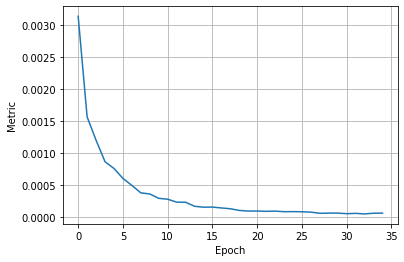

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.


In [44]:
channels = [2, 4, 6, 8]
h_sizes = [21, 24, 28, 30]
MACs_per_channels = []
params_per_channels = []
MACs_per_sizes = []
params_per_sizes = []

for channel in channels:
    cfg = TaskConfig(num_epochs=35, cnn_out_channels=channel, hidden_size=32)
    distil_model, opt, scheduler = define_model(cfg)

    mdl_dict = train(baseline_model, distil_model, opt, scheduler, softmax_T,
                      melspec_train, cfg, loss_coeffs,
                      val_loader, melspec_val)
    macs, params = profile(distil_model, (torch.randn(1, config.n_mels, 100).cuda(),))
    MACs_per_channels.append(macs)
    params_per_channels.append(params)

for size in h_sizes:
    cfg = TaskConfig(num_epochs=35, cnn_out_channels=8, hidden_size=size)
    distil_model, opt, scheduler = define_model(cfg)

    mdl_dict = train(baseline_model, distil_model, opt, scheduler, softmax_T,
                      melspec_train, cfg, loss_coeffs,
                      val_loader, melspec_val)
    macs, params = profile(distil_model, (torch.randn(1, config.n_mels, 100).cuda(),))
    MACs_per_sizes.append(macs)
    params_per_sizes.append(params)

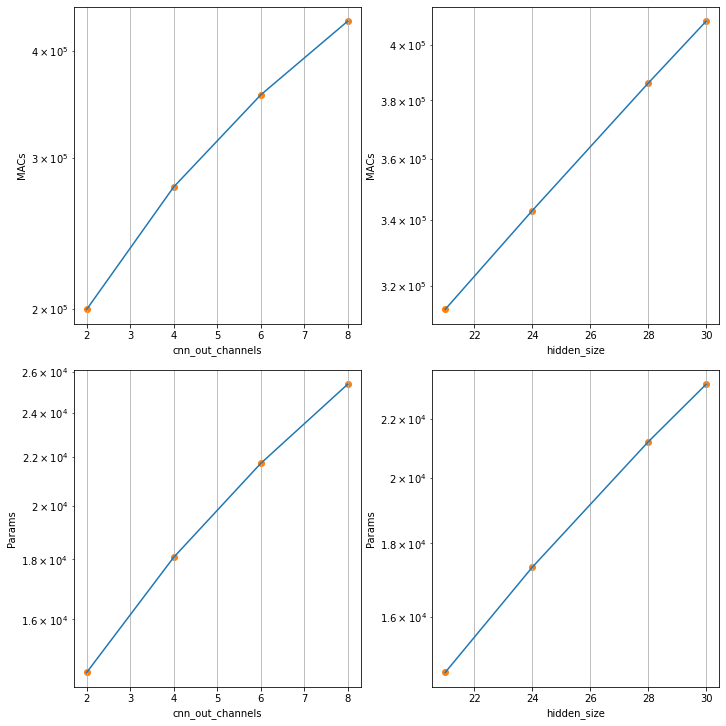

In [55]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(channels, MACs_per_channels)
plt.scatter(channels, MACs_per_channels, color="tab:orange")
plt.ylabel('MACs')
plt.xlabel('cnn_out_channels')
plt.semilogy()
plt.grid()
plt.subplot(2, 2, 2)
plt.plot(h_sizes, MACs_per_sizes)
plt.scatter(h_sizes, MACs_per_sizes, color="tab:orange")
plt.ylabel('MACs')
plt.xlabel('hidden_size')
plt.semilogy()
plt.grid()
plt.subplot(2, 2, 3)
plt.plot(channels, params_per_channels)
plt.scatter(channels, params_per_channels, color="tab:orange")
plt.ylabel('Params')
plt.xlabel('cnn_out_channels')
plt.semilogy()
plt.grid()
plt.subplot(2, 2, 4)
plt.plot(h_sizes, params_per_sizes)
plt.scatter(h_sizes, params_per_sizes, color="tab:orange")
plt.ylabel('Params')
plt.xlabel('hidden_size')
plt.semilogy()
plt.grid()
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.)
plt.show()

При помощи логарифмической шкалы можно заметить, что зависимость сложности модели от
cnn_out_channels скорее линейная, а от hidden_size скорее экспоненциальная. А значит, если мы сильнее снизим
hidden_size, при этом немного подняв число каналов в свёрточном слое -- мы всё равно выигрываем.

Тут дальше должен быть grid_search по параметрам cnn_channels и hidden_size. Код я напишу, но не факт, что буду
запускать, ясно, что работать он будет долго. Зато на выходе мы должны получить лучшую с точки зрения MACs и params модель,
показывающую приемлемое качество.

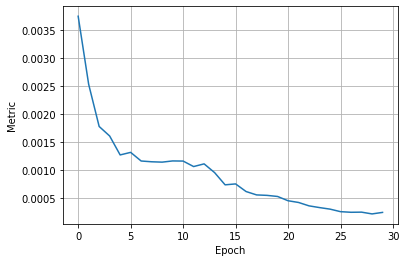

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.


54it [00:01, 50.73it/s]


In [228]:
channels = [2, 4, 6, 8]
h_sizes = [12, 14, 16, 18]

MAC_matrix = np.empty((4, 4), np.float32)
params_matrix = np.empty((4, 4), np.float32)
val_matrix = np.empty((4, 4), np.float32)

for i, channel in enumerate(channels):
    for j, size in enumerate(h_sizes):
        cfg = TaskConfig(num_epochs=30,
                         cnn_out_channels=channel,
                         hidden_size=size)
        distil_model, opt, scheduler = define_model(cfg)
        mdl_name = f"distil_h_{size}_c_{channel}"

        mdl_dict = train(baseline_model, distil_model, opt, scheduler, softmax_T,
                          melspec_train, cfg, loss_coeffs,
                          val_loader, melspec_val, model_name=mdl_name)
        macs, params = profile(distil_model, (torch.randn(1, cfg.n_mels, 100).cuda(),))
        val = validation(distil_model, val_loader, melspec_val, cfg.device)
        val_matrix[i, j] = val
        MAC_matrix[i, j] = macs
        params_matrix[i, j] = params

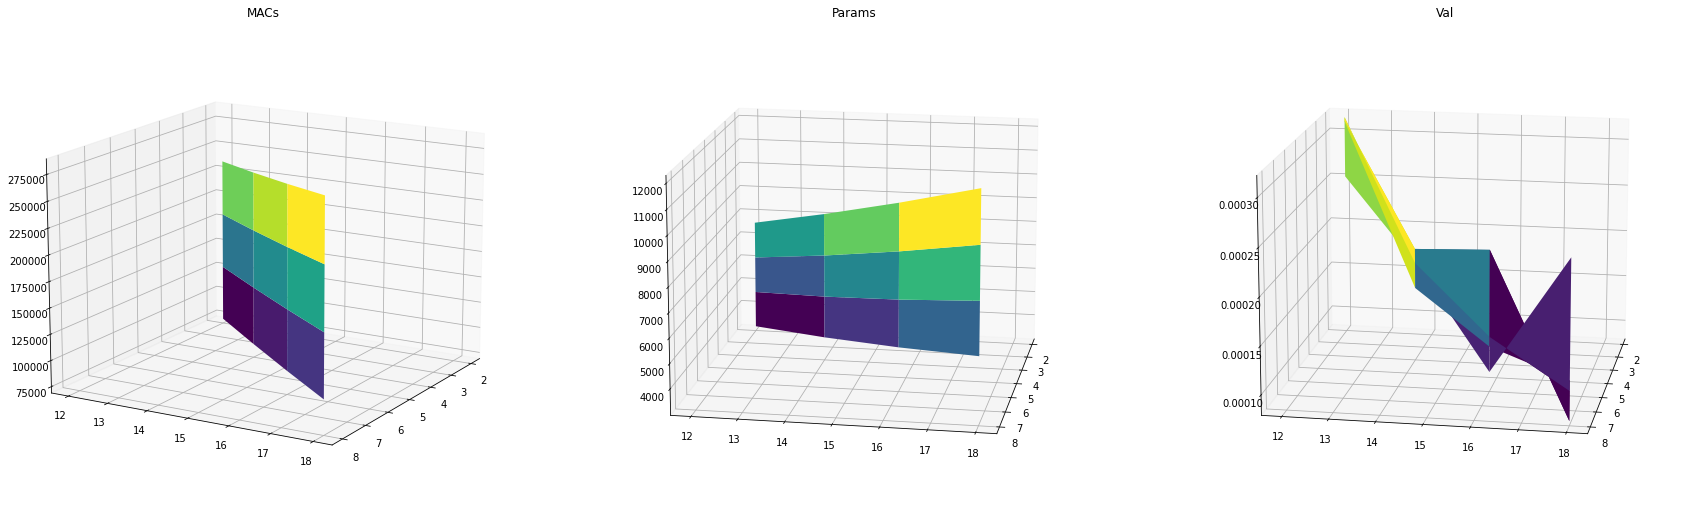

In [254]:
view_point = (15, 30)
fig = plt.figure(figsize=(30, 10))
ax = [fig.add_subplot(1, 3, 1, projection='3d'), fig.add_subplot(1, 3, 2, projection='3d'),
      fig.add_subplot(1, 3, 3, projection='3d')]

ax[0].set(title="MACs")
ax[1].set(title="Params")
ax[2].set(title="Val")

ax[0].plot_surface(channels, h_sizes, MAC_matrix, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax[1].plot_surface(channels, h_sizes, params_matrix, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax[2].plot_surface(channels, h_sizes, val_matrix, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')

ax[0].view_init(elev=view_point[0], azim=view_point[1])
ax[1].view_init(elev=view_point[0], azim=10)
ax[2].view_init(elev=view_point[0], azim=10)

plt.show()

### Сжатие fp16

Здесь я попробую сжать модель в прямом смысле этого слова, переведя все её веса в тип float16. Таким образом мы должны гарантированно получить
двухкратный выигрыш в занимаемой памяти.

Вспомним, что в LogMelspec мы клипаем значения до max(float32) и min(float32), и это поведение нам нужно поменять, для работы с fp16:

In [28]:
# Очень просто исправляем класс с помощью наследования
class LogMelspecFp16(LogMelspec):
    def __call__(self, batch):
        # print(batch.dtype)
        return torch.log(self.melspec(batch).clamp_(min=1e-4, max=1e5).half())

melspec_train_fp16 = LogMelspecFp16(is_train=True, config=TaskConfig)
melspec_val_fp16 = LogMelspecFp16(is_train=False, config=TaskConfig)

Теперь обучаем модель. Возьмём для начала бейзлайновую модель, просто срежем точность её весов до float16, а потом уже будем издеваться над
нашими дистилированными моделями. Не забываем так же, что сейчас learning_rate в конфиге порядка 3e-4, а это уже на грани машинной точности,
поэтому, немного его поднимем.

In [103]:
fp16_baseline_config = TaskConfig(learning_rate=1e-3, weight_decay=1e-3, hidden_size=32)
fp16_model = CRNN(fp16_baseline_config).to(fp16_baseline_config.device).half()
model_name="fp16_baseline"

opt = torch.optim.Adam(
    fp16_model.parameters(),
    lr=fp16_baseline_config.learning_rate,
    weight_decay=fp16_baseline_config.weight_decay,
    eps=1e-4 # про параметры адама тоже помним. Зачем я вообще использую для этого адам....
)

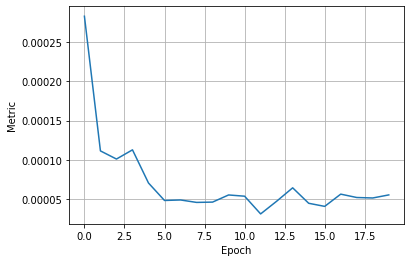

END OF EPOCH 19


In [104]:
best_val = 1
history = defaultdict(list)
for n in range(TaskConfig.num_epochs):
    train_epoch(fp16_model, opt, train_loader,
                melspec_train_fp16, fp16_baseline_config.device, scheduler=scheduler)

    au_fa_fr = validation(fp16_model, val_loader,
                          melspec_val_fp16, fp16_baseline_config.device)
    history['val_metric'].append(au_fa_fr)

    if au_fa_fr < best_val:
        fp16_baseline_dict = {'model': deepcopy(fp16_model.state_dict()),
                         'opt': deepcopy(opt.state_dict())}
        best_val = au_fa_fr


    clear_output()
    plt.plot(history['val_metric'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()

    print('END OF EPOCH', n)

fp16_model = CRNN(config=fp16_baseline_config).to(fp16_baseline_config.device).half()
fp16_model.load_state_dict(fp16_baseline_dict["model"])
torch.save(fp16_baseline_dict, MODEL_FOLDER + f"{model_name}.pt")

In [148]:
get_model_info(fp16_model, val_loader, melspec_val_fp16, fp16_baseline_config, name=model_name, is_quatized=True)

54it [00:01, 40.38it/s]


Fp16_baseline | Elapsed time : 4.70
Значение метрики для модели: 4.4264608622745756e-05
Максимально допустимое значение метрики: 5.500000000000001e-05
Baseline MACs: INCORRECT
Baseline params: INCORRECT
Размер свёрточного слоя в байтах: 1616
Размер рекуррентного слоя в байтах: 46848
Размер слоя attention в байтах: 2178
Размер классификационного слоя в байтах: 132


Можно заметить, что обученная модель в fp16 во-первых достигает приемлемого качества,
во-вторых значительно меньше, чем аналогичная модель в fp32. Мы знаем, что переход в fp16, и впринципе квантизация ломает
профилирование thop, и корректно считать MACs уже не получится, но мы так же знаем,
что значение FLOPs, и, как следствие, MACs от изменения формата представления чисел в памяти не меняется.
Поэтому значение MACs этой модели всё ещё равно значению MACs у исходной бейзлайновой модели (что-то около 500к).

Так же довольно очевидно (я даже не буду это проверять), что обучить модель fp16 с нуля будет профитнее с точки зрения качества,
чем взять обученную модель, и перевести её в fp16.

### Quatization

Я хотел применить тут QAT, но я не понял, куда можно его накинуть, не меняя
при этом архитектуру модели. Поэтому я попробую разобраться (для начала на бейзлайновой модели), как
квантизовать модель в INT8. А именно буду накидывать динамическую квантизацию на два наиболее тяжеловесных слоя:
рекуррентный и attention.

In [260]:

q_config = TaskConfig(hidden_size=32, device="cpu")
q_model_dict = torch.load(MODEL_FOLDER + "baseline.pt")
q_model_dict = q_model_dict["model"]
q_model = CRNN(q_config).to(q_config.device)
q_model.load_state_dict(q_model_dict)
model_name="q_baseline_model"
q_model = torch.quantization.quantize_dynamic(
    q_model,  # the original model
    {torch.nn.GRU, Attention},  # a set of layers to dynamically quantize
    dtype=torch.qint8)

q_melspec_val = LogMelspec(is_train=False, config=q_config)
get_model_info(q_model, val_loader, q_melspec_val, q_config, name=model_name,
               is_quatized=True)
q_model_dict = {"model": q_model.state_dict()}
torch.save(q_model_dict, MODEL_FOLDER + f"{model_name}.pt")

54it [00:05, 10.31it/s]


Q_baseline_model | Elapsed time : 8.11
Значение метрики для модели: 3.896057055248211e-05
Максимально допустимое значение метрики: 5.500000000000001e-05
Baseline MACs: INCORRECT
Baseline params: INCORRECT
Размер свёрточного слоя в байтах: 3232
Размер рекуррентного слоя в байтах: 0
Размер слоя attention в байтах: 0
Размер классификационного слоя в байтах: 264


Отличное сжатие! А вообще для int8 сломался ещё и подсчёт размера квантизованных слоёв, поэтому напишем его ручками:

In [98]:
def count_quatized_size(model):
    atn = [p for p in model.attention.energy]
    return (model.gru.input_size * model.gru.hidden_size + model.gru.hidden_size) * q_model.gru.num_layers * 2,\
    (atn[0].in_features * atn[0].out_features + atn[0].out_features +
    atn[2].in_features * atn[2].out_features + atn[2].out_features) * 2

gru_size, attn_size = count_quatized_size(q_model)
print("Размер рекуррентного слоя в байтах:", gru_size)
print("Размер слоя attention в байтах:", attn_size)

Размер рекуррентного слоя в байтах: 18560
Размер слоя attention в байтах: 2178


Остаётся только пригнать лучшие настройки для дистилированной модели, обучить её в fp16
и добавить динамической квантизации, итого мы должны получить мелкую, быструю модель с хорошим качеством.

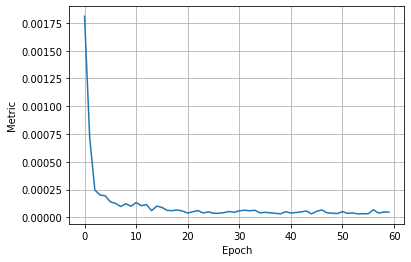

In [152]:
fp16_baseline_cfg = TaskConfig(learning_rate=1e-3, weight_decay=1e-3, hidden_size=32)
fp16_baseline_dict = torch.load(MODEL_FOLDER + "fp16_baseline.pt")
fp16_baseline = CRNN(config=fp16_baseline_cfg).to(fp16_baseline_cfg.device).half()
fp16_baseline.load_state_dict(fp16_baseline_dict["model"])
# Будем дистилировать бейзлайновую модель, обученную на fp16
best_model_cfg = TaskConfig(num_epochs=60, cnn_out_channels=4, hidden_size=14, learning_rate=1e-3, weight_decay=1e-3)
model_name = "best_model"
best_model = CRNN(best_model_cfg).to(best_model_cfg.device).half()
opt = torch.optim.Adam(
    best_model.parameters(),
    lr=best_model_cfg.learning_rate,
    weight_decay=best_model_cfg.weight_decay,
    eps=1e-4
)

_, best_model_dict = train(fp16_baseline, best_model, opt, scheduler, softmax_T,
                          melspec_train_fp16, best_model_cfg, loss_coeffs,
                          val_loader, melspec_val_fp16)
torch.save(best_model_dict, MODEL_FOLDER + f"{model_name}.pt")

In [154]:
get_model_info(best_model, val_loader, melspec_val_fp16, best_model_cfg, name=model_name, is_quatized=True)

54it [00:01, 47.81it/s]


Best_model | Elapsed time : 3.30
Значение метрики для модели: 4.693270050051475e-05
Максимально допустимое значение метрики: 5.500000000000001e-05
Baseline MACs: INCORRECT
Baseline params: INCORRECT
Размер свёрточного слоя в байтах: 808
Размер рекуррентного слоя в байтах: 9912
Размер слоя attention в байтах: 450
Размер классификационного слоя в байтах: 60


In [155]:
import tempfile

def get_size_in_megabytes(model):
    # https://pytorch.org/tutorials/recipes/recipes/dynamic_quantization.html#look-at-model-size
    with tempfile.TemporaryFile() as f:
        torch.save(model.state_dict(), f)
        size = f.tell() / 2**20
    return size

print("Вес бейзлайновой модели:\t\t\t", get_size_in_megabytes(baseline_model))
print("Вес конечной модели (пока без квантизации):\t", get_size_in_megabytes(best_model))

Вес бейзлайновой модели:			 0.10246467590332031
Вес конечной модели (пока без квантизации):	 0.014170646667480469


Теперь добавим квантизацию на слои GRU и Attention. Немного перепишем модель,
чтобы свёрточный слой принимал вход в формате float32, а выдавал в формате float16 (это делается потому
что conv не умеет работать с float16 на CPU, а квантизация не умеет работать на GPU).

In [199]:
class CRNN_(CRNN):
    def forward(self, input):
        input = input.unsqueeze(dim=1)
        conv_output = self.conv(input).transpose(-1, -2).half()
        gru_output, _ = self.gru(conv_output)
        contex_vector = self.attention(gru_output)
        output = self.classifier(contex_vector)
        return output

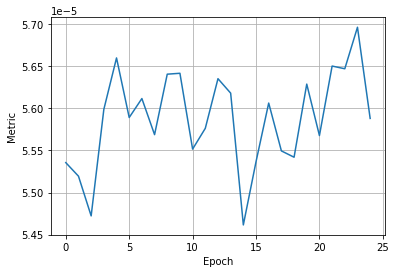

54it [00:04, 11.13it/s]


Best_model | Elapsed time : 6.63
Значение метрики для модели: 5.481910862114919e-05
Максимально допустимое значение метрики: 5.500000000000001e-05
Baseline MACs: INCORRECT
Baseline params: INCORRECT
Размер свёрточного слоя в байтах: 1616
Размер рекуррентного слоя в байтах: 0
Размер слоя attention в байтах: 900
Размер классификационного слоя в байтах: 120


In [218]:
f32_cfg = TaskConfig(num_epochs=25, cnn_out_channels=4,
                     hidden_size=14, learning_rate=1e-5, weight_decay=0)
f32 = CRNN_(f32_cfg).to(f32_cfg.device).half()
f32.load_state_dict(best_model_dict["model"])
f32.conv.to(torch.float32)
melspec_val_f32 = LogMelspec(is_train=False, config=f32_cfg)
melspec_train_f32 = LogMelspec(is_train=True, config=f32_cfg)
baseline_model.to(f32_cfg.device)

opt = torch.optim.AdamW(
    f32.parameters(),
    lr=f32_cfg.learning_rate,
    weight_decay=f32_cfg.weight_decay,
)

# Дообучаем раширенный до float32 свёрточный слой
_, best_model_dict = train(baseline_model, f32, opt, scheduler, softmax_T,
                          melspec_train_f32, f32_cfg, loss_coeffs,
                          val_loader, melspec_val_f32)
torch.save(best_model_dict, MODEL_FOLDER + f"{model_name}.pt")
f32.load_state_dict(best_model_dict["model"])

f32.to("cpu")
f32_cfg.device="cpu"
melspec_train_f32 = LogMelspec(is_train=True, config=f32_cfg)
melspec_val_f32 = LogMelspec(is_train=False, config=f32_cfg)
qf32 = torch.quantization.quantize_dynamic(
    f32,
    {torch.nn.GRU},
    dtype=torch.qint8)
get_model_info(qf32, val_loader, melspec_val_f32, f32_cfg, name=model_name, is_quatized=True)

In [219]:
print("Вес бейзлайновой модели:\t\t\t", get_size_in_megabytes(baseline_model))
print("Вес конечной модели (пока без квантизации):\t", 0.010867927551269531)
# get_size_in_megabytes(qf32)

Вес бейзлайновой модели:			 0.10246467590332031
Вес конечной модели (пока без квантизации):	 0.012867927551269531


In [232]:
# Накидываю квантизацию на гру и атеншен
f32.to("cpu")
f32_cfg.device="cpu"
melspec_train_f32 = LogMelspec(is_train=True, config=f32_cfg)
melspec_val_f32 = LogMelspec(is_train=False, config=f32_cfg)
qf32 = torch.quantization.quantize_dynamic(
    f32,  # the original model
    {torch.nn.GRU},
    dtype=torch.qint8)
get_model_info(qf32, val_loader, melspec_val_f32, f32_cfg, name=model_name, is_quatized=True)

54it [00:04, 11.18it/s]


Best_model | Elapsed time : 7.60
Значение метрики для модели: 5.481910862114919e-05
Максимально допустимое значение метрики: 5.500000000000001e-05
Baseline MACs: INCORRECT
Baseline params: INCORRECT
Размер свёрточного слоя в байтах: 1616
Размер рекуррентного слоя в байтах: 0
Размер слоя attention в байтах: 900
Размер классификационного слоя в байтах: 120


Подведём итог нашей работы:

In [233]:
baseline_weight = get_size_in_megabytes(baseline_model)
result_weight = get_size_in_megabytes(qf32)
sec_2_input = torch.randn(1, config.n_mels, 201).cuda()
baseline_macs, _ = profile(deepcopy(baseline_model), (sec_2_input,))
f32_best_model = CRNN_(f32_cfg).to("cuda")
result_macs, _ = profile(deepcopy(f32_best_model), (sec_2_input,))


print("Вес бейзлайновой модели:\t\t\t", get_size_in_megabytes(baseline_model))
print("Скорость бейзлайновой модели (в MACs):\t\t\t", baseline_macs)
print("Вес конечной модели (пока без квантизации):\t", get_size_in_megabytes(qf32))
print("Скорость конечной модели (в MACs):\t\t\t", result_macs)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
Вес бейзлайновой модели:			 0.10240364074707031
Скорость бейзлайновой модели (в MACs):			 904608.0
Вес конечной модели (пока без квантизации):	 0.012867927551269531
Скорость конечной модели (в MACs):			 288954.0


Не бог весть что, но лучше я не смог.

### Сравнение моделей

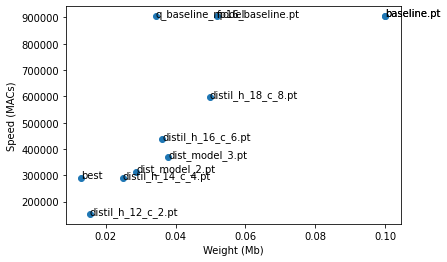

In [272]:
fp16_exp = ["baseline.pt", "fp16_baseline.pt"]
fp16_cfgs = [config, TaskConfig(learning_rate=1e-3, weight_decay=1e-3, hidden_size=32)]
qint8_exp = ["baseline.pt", "q_baseline"]
qint8_cfgs = [config, TaskConfig(hidden_size=32, device="cpu")]
distil_exp = ["baseline.pt", "dist_model_2.pt",
              "dist_model_3.pt",
              "distil_h_12_c_2.pt", "distil_h_12_c_4.pt", "distil_h_12_c_6.pt", "distil_h_12_c_8.pt",
              "distil_h_14_c_2.pt", "distil_h_14_c_4.pt", "distil_h_14_c_6.pt", "distil_h_14_c_8.pt",
              "distil_h_16_c_2.pt", "distil_h_16_c_4.pt", "distil_h_16_c_6.pt", "distil_h_16_c_8.pt",
              "distil_h_18_c_2.pt", "distil_h_18_c_4.pt", "distil_h_18_c_6.pt", "distil_h_18_c_8.pt"]
distil_cfgs = [config, TaskConfig(num_epochs=35, cnn_out_channels=4, hidden_size=16),
              TaskConfig(num_epochs=35, cnn_out_channels=4, hidden_size=20)]
for i, channel in enumerate(channels):
    for j, size in enumerate(h_sizes):
        distil_cfgs.append(TaskConfig(num_epochs=30,
                         cnn_out_channels=channel,
                         hidden_size=size))

colors = ["tab:blue", "tab:orange", "tab:red"]
for i, exp in enumerate(fp16_exp):
    cfg = fp16_cfgs[i]
    mdl_dict = torch.load(MODEL_FOLDER + exp)
    if i == 1:
        mdl = CRNN(config=cfg).to(cfg.device).half()
    else:
        mdl = CRNN(config=cfg).to(cfg.device)
    mdl.load_state_dict(mdl_dict["model"])
    mdl_weight = get_size_in_megabytes(mdl)
    mdl_macs = CRNN(config=cfg).to(cfg.device)
    mdl_macs, _ = profile(deepcopy(mdl_macs), (sec_2_input,))
    plt.scatter(mdl_weight, mdl_macs, color=colors[0])
    plt.text(mdl_weight, mdl_macs, exp)



mdl_weight = get_size_in_megabytes(q_model)
mdl_macs = CRNN(config=cfg).to(cfg.device)
mdl_macs, _ = profile(deepcopy(baseline_model), (sec_2_input,))
plt.scatter(mdl_weight, mdl_macs, color=colors[0])
plt.text(mdl_weight, mdl_macs, "q_baseline_model")

for i, exp in enumerate(distil_exp):
    try:
        cfg = distil_cfgs[i]
        mdl_dict = torch.load(MODEL_FOLDER + exp)
        mdl = CRNN(config=cfg).to(cfg.device)
        mdl.load_state_dict(mdl_dict["model"])
        mdl_weight = get_size_in_megabytes(mdl)
        mdl_macs = CRNN(config=cfg).to(cfg.device)
        mdl_macs, _ = profile(deepcopy(mdl_macs), (sec_2_input,))
        plt.scatter(mdl_weight, mdl_macs, color=colors[0])
        plt.text(mdl_weight, mdl_macs, exp)
    except:
        pass

plt.scatter(result_weight, result_macs, color=colors[0])
plt.text(result_weight, result_macs, "best")

clear_output()
plt.xlabel("Weight (Mb)")
plt.ylabel("Speed (MACs)")
plt.show()

In [265]:
len(distil_cfgs)

2

### Кладбище хороших идей

In [ ]:
class CRNN_(CRNN):
    def forward(self, input):
        input = torch.quantization.QuantStub()(input)
        input = input.unsqueeze(dim=1)
        conv_output = self.conv(input).transpose(-1, -2)
        gru_output, _ = self.gru(conv_output)
        contex_vector = self.attention(gru_output)
        output = self.classifier(contex_vector)
        output = torch.quantization.DeQuantStub()(output)
        return output